In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)

In [35]:
smallset = pd.read_csv('filtered_data.csv')
largeset = pd.read_csv('remaining_data.csv')
fulldf = pd.read_csv('smoking_driking_dataset_Ver01.csv')
print(f'Smaller set: {smallset.shape}')
print(f'Larger set: {largeset.shape}')

Smaller set: (359012, 24)
Larger set: (632334, 24)


In [36]:
fulldf_niche = fulldf[(fulldf["sex"] == "Male") & (fulldf["age"] >= 45) & (fulldf["age"] <= 55)]
fulldf_niche.shape

(184461, 24)

In [37]:
file = 'filtered_data.csv'
nichefile = pd.read_csv('target_data.csv')
largeset = pd.read_csv('source_data.csv')
#df = pd.read_csv(file)
df = nichefile.copy()

In [38]:
print(f'Niche shape: {df.shape}')
print(f'Large set shape: {largeset.shape}')

Niche shape: (184461, 24)
Large set shape: (806885, 24)


In [39]:
print("First 5 rows of the dataset:")
display(df.head())

First 5 rows of the dataset:


,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,DBP,BLDS,tot_chole,HDL_chole,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
0,Male,50,175,80,91.0,1.5,1.2,1.0,1.0,145.0,87.0,95.0,201.0,76.0,104.0,106.0,17.6,1.0,1.1,29.0,34.0,18.0,1.0,N
1,Male,50,165,60,80.0,1.0,1.2,1.0,1.0,138.0,82.0,101.0,199.0,61.0,117.0,104.0,13.8,1.0,0.8,19.0,12.0,25.0,1.0,N
2,Male,50,165,55,75.0,1.2,1.5,1.0,1.0,142.0,92.0,99.0,218.0,77.0,95.0,232.0,13.8,3.0,0.8,29.0,40.0,37.0,3.0,Y
3,Male,55,170,75,84.0,1.2,0.9,1.0,1.0,145.0,85.0,104.0,217.0,56.0,141.0,100.0,15.1,1.0,0.8,32.0,23.0,26.0,1.0,Y
4,Male,45,155,55,79.2,1.0,1.0,1.0,1.0,118.0,70.0,90.0,183.0,42.0,130.0,55.0,12.9,1.0,0.8,19.0,14.0,19.0,1.0,N


Summary Statistics

In [40]:
display(df.describe())

,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,DBP,BLDS,tot_chole,HDL_chole,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd
count,184461.000000,184461.000000,184461.000000,184461.000000,184461.000000,184461.000000,184461.000000,184461.000000,184461.000000,184461.000000,184461.000000,184461.000000,184461.000000,184461.000000,184461.000000,184461.000000,184461.000000,184461.000000,184461.000000,184461.000000,184461.000000,184461.000000
mean,49.789576,167.953090,69.629895,85.135829,1.030782,1.029928,1.023452,1.022541,124.963250,79.101116,106.336732,198.772223,52.458362,115.452199,163.227295,15.251855,1.106467,0.965566,28.644781,30.478058,54.596018,2.136327
std,4.021220,5.807509,9.976833,7.683196,0.556504,0.550919,0.151335,0.148436,13.618497,9.713718,28.971032,39.441230,13.468784,36.616139,124.466187,1.119723,0.471376,0.471110,35.298766,26.286091,67.219923,0.787709
min,45.000000,145.000000,40.000000,32.000000,0.100000,0.100000,1.000000,1.000000,75.000000,40.000000,30.000000,55.000000,1.000000,1.000000,7.000000,4.900000,1.000000,0.100000,1.000000,1.000000,1.000000,1.000000
25%,45.000000,165.000000,65.000000,80.000000,0.800000,0.800000,1.000000,1.000000,116.000000,72.000000,92.000000,173.000000,43.000000,91.000000,91.000000,14.600000,1.000000,0.800000,21.000000,18.000000,23.000000,1.000000
50%,50.000000,170.000000,70.000000,85.000000,1.000000,1.000000,1.000000,1.000000,124.000000,80.000000,100.000000,197.000000,51.000000,115.000000,133.000000,15.300000,1.000000,0.900000,25.000000,25.000000,35.000000,2.000000
75%,55.000000,170.000000,75.000000,90.000000,1.200000,1.200000,1.000000,1.000000,133.000000,85.000000,111.000000,223.000000,60.000000,138.000000,196.000000,16.000000,1.000000,1.100000,31.000000,35.000000,60.000000,3.000000
max,55.000000,190.000000,125.000000,130.500000,9.900000,9.900000,2.000000,2.000000,234.000000,153.000000,801.000000,2046.000000,592.000000,2026.000000,6430.000000,23.900000,6.000000,98.000000,9999.000000,3807.000000,999.000000,3.000000


Datatypes

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184461 entries, 0 to 184460
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sex               184461 non-null  object 
 1   age               184461 non-null  int64  
 2   height            184461 non-null  int64  
 3   weight            184461 non-null  int64  
 4   waistline         184461 non-null  float64
 5   sight_left        184461 non-null  float64
 6   sight_right       184461 non-null  float64
 7   hear_left         184461 non-null  float64
 8   hear_right        184461 non-null  float64
 9   SBP               184461 non-null  float64
 10  DBP               184461 non-null  float64
 11  BLDS              184461 non-null  float64
 12  tot_chole         184461 non-null  float64
 13  HDL_chole         184461 non-null  float64
 14  LDL_chole         184461 non-null  float64
 15  triglyceride      184461 non-null  float64
 16  hemoglobin        18

In [42]:
print(df.isnull().sum())
# No null values but if there were a few we would drop them
df = df.dropna()
largeset = largeset.dropna()

sex                 0
age                 0
height              0
weight              0
waistline           0
sight_left          0
sight_right         0
hear_left           0
hear_right          0
SBP                 0
DBP                 0
BLDS                0
tot_chole           0
HDL_chole           0
LDL_chole           0
triglyceride        0
hemoglobin          0
urine_protein       0
serum_creatinine    0
SGOT_AST            0
SGOT_ALT            0
gamma_GTP           0
SMK_stat_type_cd    0
DRK_YN              0
dtype: int64


# Outliers #

In [43]:
# Calculate and display outliers using IQR method for numerical columns

def outliers(df):
    numerical_cols = df.select_dtypes(include=[np.number]).columns

    for col in numerical_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        
        print(f"{col}:")
        print(f"  Outlier count: {len(outliers)}")
        print(f"  Outlier percentage: {len(outliers)/len(df)*100:.2f}%")
        print(f"  Range: [{lower_bound:.2f}, {upper_bound:.2f}]")
        if len(outliers) > 0:
            print(f"  Min outlier: {outliers[col].min():.2f}")
            print(f"  Max outlier: {outliers[col].max():.2f}")
        print()

outliers(df)
#outliers(largeset)

age:
  Outlier count: 0
  Outlier percentage: 0.00%
  Range: [30.00, 70.00]

height:
  Outlier count: 14358
  Outlier percentage: 7.78%
  Range: [157.50, 177.50]
  Min outlier: 145.00
  Max outlier: 190.00

weight:
  Outlier count: 4594
  Outlier percentage: 2.49%
  Range: [50.00, 90.00]
  Min outlier: 40.00
  Max outlier: 125.00

waistline:
  Outlier count: 2094
  Outlier percentage: 1.14%
  Range: [65.00, 105.00]
  Min outlier: 32.00
  Max outlier: 130.50

sight_left:
  Outlier count: 4202
  Outlier percentage: 2.28%
  Range: [0.20, 1.80]
  Min outlier: 0.10
  Max outlier: 9.90

sight_right:
  Outlier count: 3957
  Outlier percentage: 2.15%
  Range: [0.20, 1.80]
  Min outlier: 0.10
  Max outlier: 9.90

hear_left:
  Outlier count: 4326
  Outlier percentage: 2.35%
  Range: [1.00, 1.00]
  Min outlier: 2.00
  Max outlier: 2.00

hear_right:
  Outlier count: 4158
  Outlier percentage: 2.25%
  Range: [1.00, 1.00]
  Min outlier: 2.00
  Max outlier: 2.00

SBP:
  Outlier count: 3996
  Outlier 

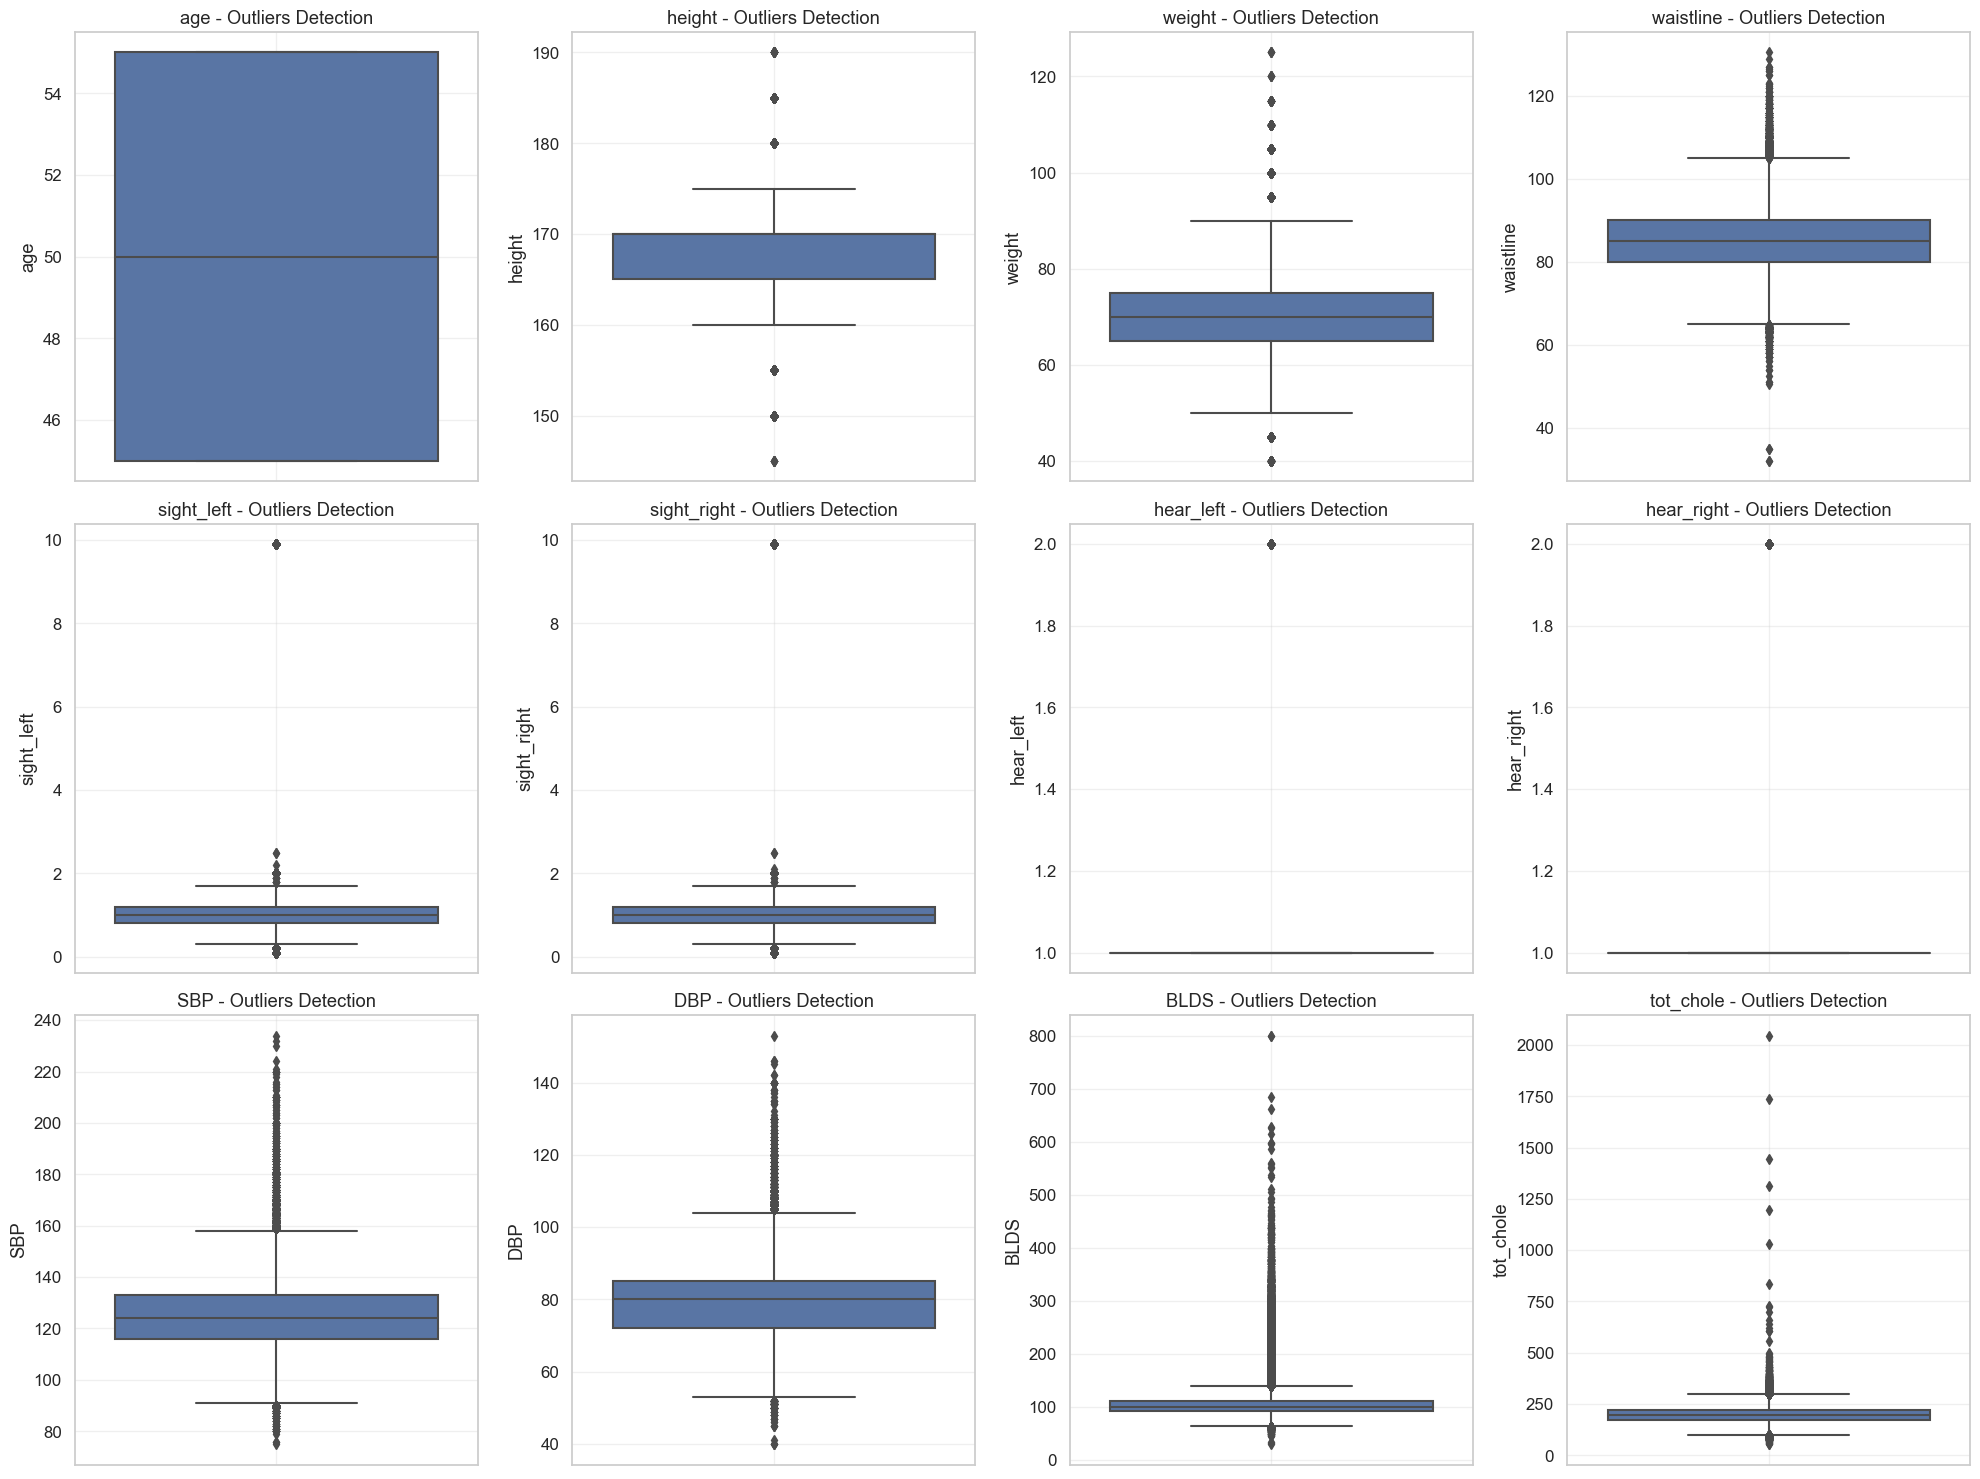

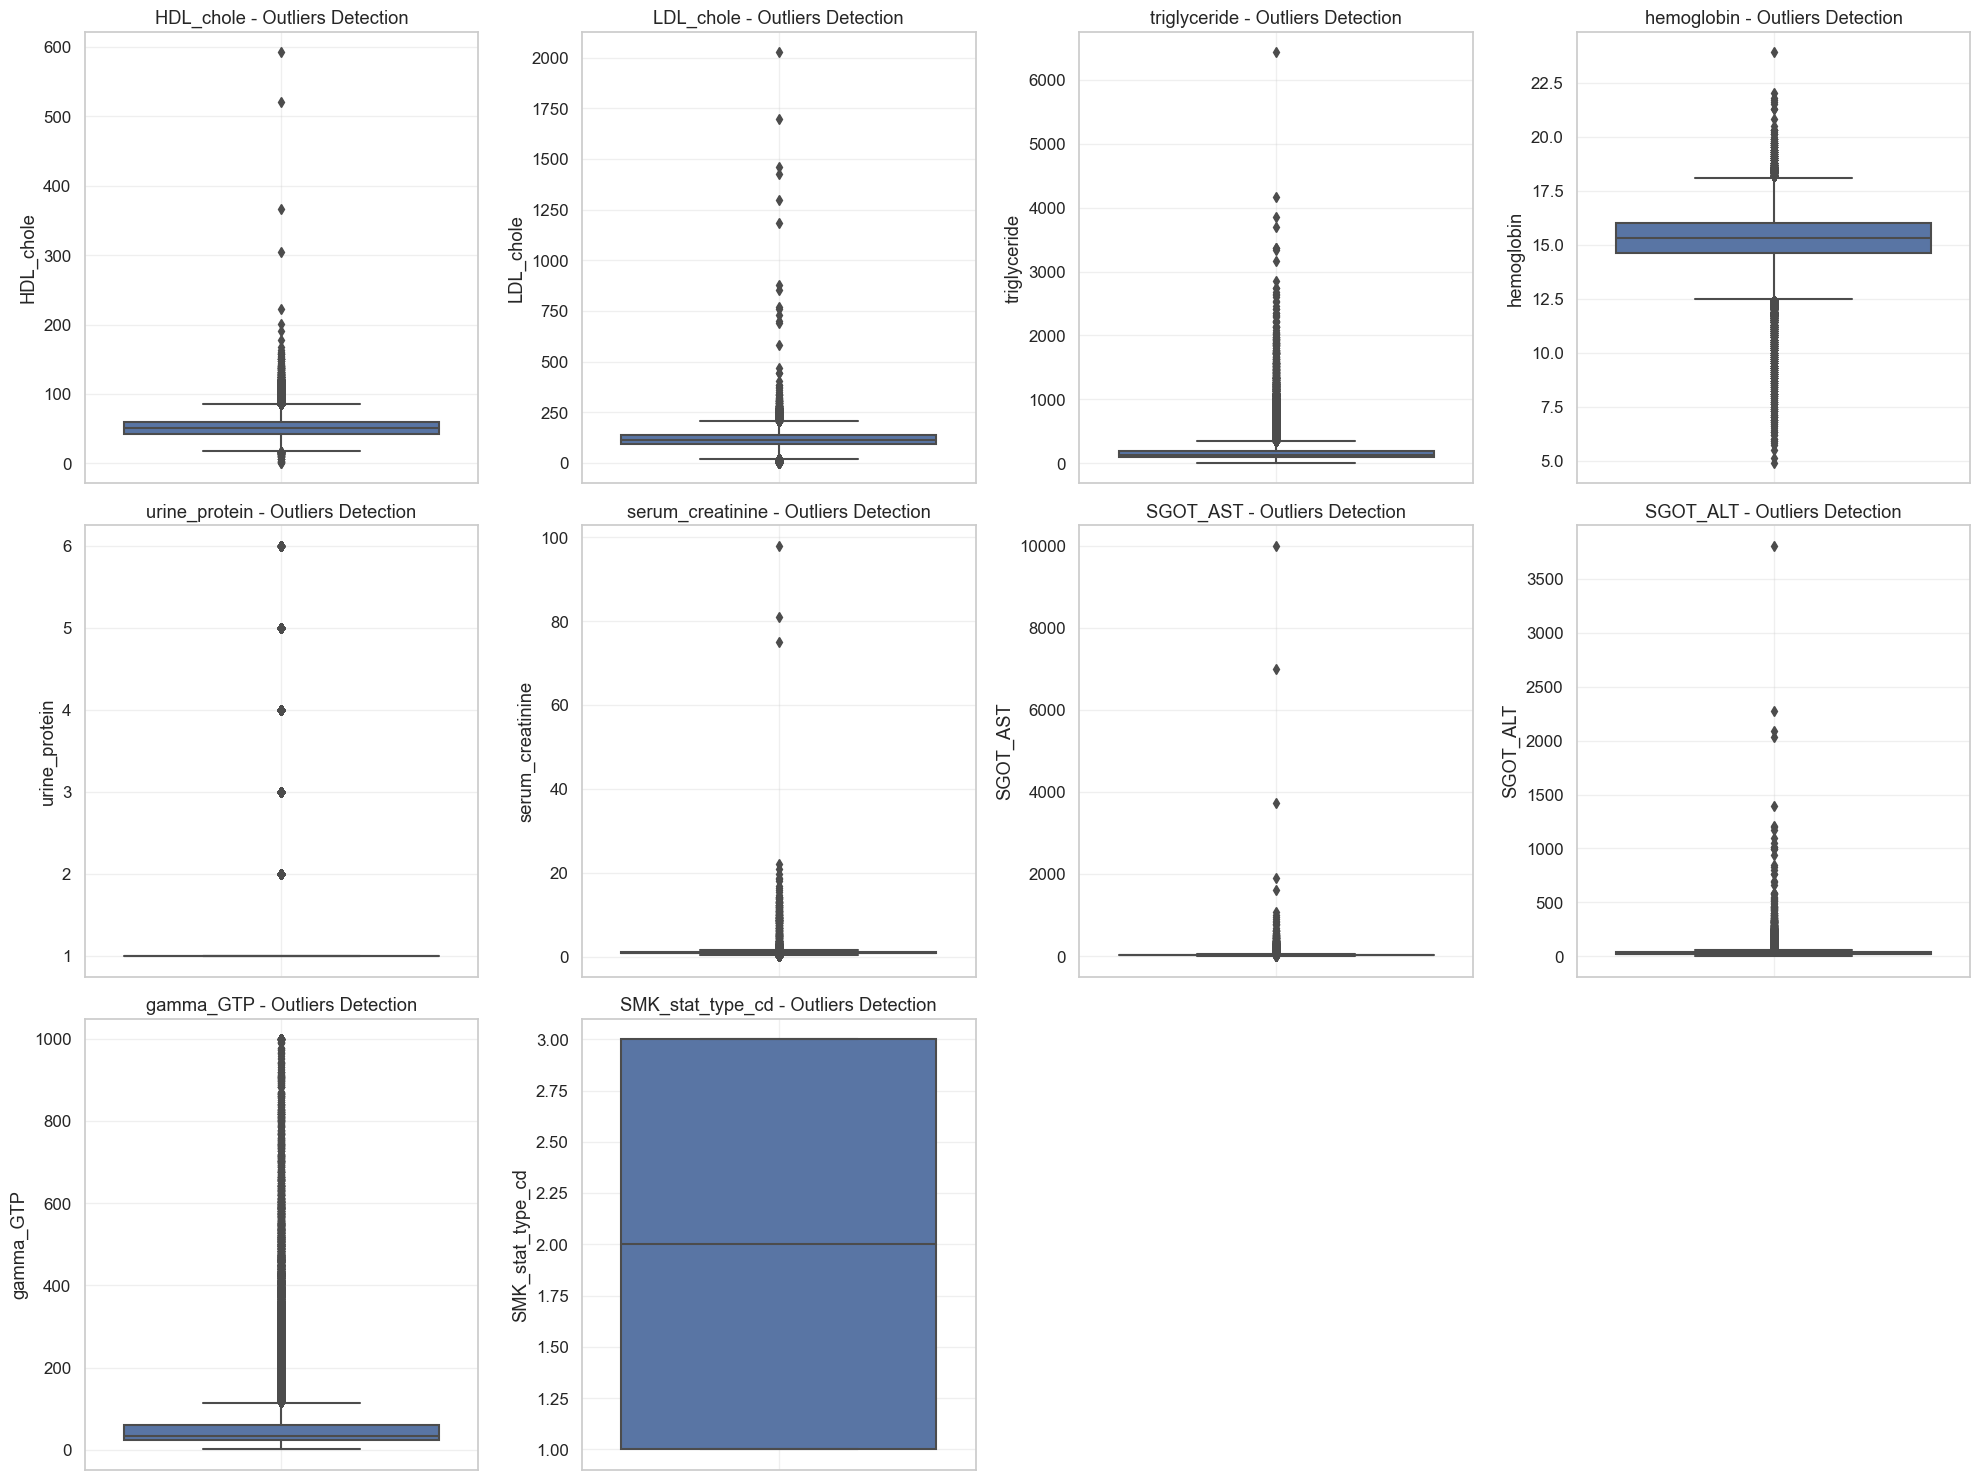

In [44]:
# Create visualizations for outliers
def outlier_illustrate(df):
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    axes = axes.flatten()

    for i, col in enumerate(numerical_cols[:12]):  # Show first 12 numerical columns
        # Calculate outlier bounds for this column
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Create box plot
        sns.boxplot(data=df, y=col, ax=axes[i])
        axes[i].set_title(f'{col} - Outliers Detection')
        axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Create additional plots for remaining numerical columns if any
    if len(numerical_cols) > 12:
        remaining_cols = numerical_cols[12:]
        n_remaining = len(remaining_cols)
        n_cols = 4
        n_rows = (n_remaining + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
        if n_rows == 1:
            axes = [axes] if n_remaining == 1 else axes
        else:
            axes = axes.flatten()
        
        for i, col in enumerate(remaining_cols):
            sns.boxplot(data=df, y=col, ax=axes[i])
            axes[i].set_title(f'{col} - Outliers Detection')
            axes[i].grid(True, alpha=0.3)
        
        # Hide empty subplots
        for j in range(i+1, len(axes)):
            axes[j].set_visible(False)
        
        plt.tight_layout()
        plt.show()
outlier_illustrate(df)
#outlier_illustrate(largeset)

In [45]:
# --- Variable groups from dataset documentation ---
CONTINUOUS_VARS = [
    "age", "height", "weight", "sight_left", "sight_right",
    "SBP", "DBP", "BLDS", "tot_chole", "HDL_chole", "LDL_chole",
    "triglyceride", "hemoglobin", "serum_creatinine",
    "SGOT_AST", "SGOT_ALT", "gamma_GTP", "waistline"
]

ORDINAL_VARS = ["urine_protein"]  # exclude from IQR
CATEGORICAL_VARS = ["sex", "hear_left", "hear_right", "SMK_stat_type_cd", "DRK_YN"]

# Use intersection with actual columns
cont_cols = [c for c in CONTINUOUS_VARS if c in df.columns]

def iqr_bounds(s: pd.Series):
    s = pd.to_numeric(s, errors="coerce").dropna()
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    return low, high

In [46]:
df_clean = df.copy()
largeset_clean = largeset.copy()

In [47]:
df_clean

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,DBP,BLDS,tot_chole,HDL_chole,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
0,Male,50,175,80,91.0,1.5,1.2,1.0,1.0,145.0,87.0,95.0,201.0,76.0,104.0,106.0,17.6,1.0,1.1,29.0,34.0,18.0,1.0,N
1,Male,50,165,60,80.0,1.0,1.2,1.0,1.0,138.0,82.0,101.0,199.0,61.0,117.0,104.0,13.8,1.0,0.8,19.0,12.0,25.0,1.0,N
2,Male,50,165,55,75.0,1.2,1.5,1.0,1.0,142.0,92.0,99.0,218.0,77.0,95.0,232.0,13.8,3.0,0.8,29.0,40.0,37.0,3.0,Y
3,Male,55,170,75,84.0,1.2,0.9,1.0,1.0,145.0,85.0,104.0,217.0,56.0,141.0,100.0,15.1,1.0,0.8,32.0,23.0,26.0,1.0,Y
4,Male,45,155,55,79.2,1.0,1.0,1.0,1.0,118.0,70.0,90.0,183.0,42.0,130.0,55.0,12.9,1.0,0.8,19.0,14.0,19.0,1.0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184456,Male,45,180,80,87.0,1.2,1.2,1.0,1.0,151.0,97.0,107.0,182.0,45.0,116.0,104.0,17.0,1.0,0.9,24.0,23.0,25.0,2.0,Y
184457,Male,50,175,75,81.0,0.7,0.8,1.0,1.0,140.0,80.0,97.0,211.0,56.0,129.0,129.0,14.8,1.0,0.8,26.0,19.0,47.0,3.0,Y
184458,Male,55,170,75,84.0,1.5,2.0,2.0,1.0,139.0,89.0,96.0,232.0,52.0,140.0,198.0,17.3,1.0,0.9,24.0,32.0,39.0,2.0,N
184459,Male,45,175,80,92.1,1.5,1.5,1.0,1.0,114.0,80.0,88.0,198.0,46.0,125.0,132.0,15.0,1.0,1.0,26.0,36.0,27.0,1.0,N


In [48]:
# Remove (clear errors)
df_clean = df.copy()
largeset_clean = largeset.copy()

def cleandf(df_clean):

    REMOVE_RULES = {
        "waistline": lambda s: s > 200,  # e.g., 1000 cm entries
        "serum_creatinine": lambda s: s > 20,  # mg/dL, implausible highs
        "SGOT_AST": lambda s: s > 9000,  # extreme enzyme typos
        "SGOT_ALT": lambda s: s > 9000,
        "sight_left": lambda s: s >= 5,  # 10.0 eyesight entries -> remove
        "sight_right": lambda s: s >= 5,
    }

    # Apply removal rules
    mask_keep = pd.Series(True, index=df_clean.index)
    remove_report = []
    for col, rule in REMOVE_RULES.items():
        if col in df_clean.columns:
            bad = rule(pd.to_numeric(df_clean[col], errors="coerce"))
            n_bad = int(bad.sum())
            if n_bad > 0:
                mask_keep &= ~bad
                remove_report.append((col, n_bad))

    df_clean = df_clean.loc[mask_keep]
    print("Rows removed (by column):", remove_report)

    # =========================
    # 2) CAP (winsorize at IQR)
    # =========================
    cap_report = []
    for col in cont_cols:
        if col in df_clean.columns:
            low, high = iqr_bounds(df_clean[col])
            before = pd.to_numeric(df_clean[col], errors="coerce")
            n_low = int((before < low).sum())
            n_high = int((before > high).sum())
            df_clean[col] = before.clip(lower=low, upper=high)
            cap_report.append({
                "column": col,
                "capped_low": n_low,
                "capped_high": n_high
            })

    print(pd.DataFrame(cap_report))

    # ==============================
    # 3) TRANSFORM (reduce skew with log1p)
    # ==============================
    LOG1P_VARS = [
        v for v in [
            "weight", "BLDS", "tot_chole", "HDL_chole", "LDL_chole",
            "triglyceride", "SGOT_AST", "SGOT_ALT", "gamma_GTP"
        ]
        if v in df_clean.columns
    ]

    transform_report = []
    for col in LOG1P_VARS:
        x = pd.to_numeric(df_clean[col], errors="coerce")
        n_neg = int((x < 0).sum())
        if n_neg:
            x = x.clip(lower=0)  # ensure non-negative before log1p
        df_clean[col] = np.log1p(x)
        transform_report.append({
            "column": col,
            "negatives_clipped": n_neg
        })

    print(pd.DataFrame(transform_report))
    return df_clean

df_clean = cleandf(df_clean)
largeset_clean = cleandf(largeset_clean)

Rows removed (by column): [('serum_creatinine', 5), ('SGOT_AST', 1), ('sight_left', 499), ('sight_right', 488)]
              column  capped_low  capped_high
0                age           0            0
1             height        5784         8487
2             weight        1120         3448
3         sight_left        2076         1603
4        sight_right        2072         1366
5                SBP         664         3309
6                DBP         223         2084
7               BLDS         238        13754
8          tot_chole         263         1783
9          HDL_chole          56         3764
10         LDL_chole         411         1527
11      triglyceride           0        10025
12        hemoglobin        2114          849
13  serum_creatinine         167          908
14          SGOT_AST          15        12251
15          SGOT_ALT           0        11399
16         gamma_GTP           0        15351
17         waistline         499         1577
         colum

/var/folders/1f/v0gqjxts0235tbk5cdwc65fc0000gn/T/ipykernel_25319/2885281885.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[col] = before.clip(lower=low, upper=high)
/var/folders/1f/v0gqjxts0235tbk5cdwc65fc0000gn/T/ipykernel_25319/2885281885.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[col] = before.clip(lower=low, upper=high)
/var/folders/1f/v0gqjxts0235tbk5cdwc65fc0000gn/T/ipykernel_25319/2885281885.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

              column  capped_low  capped_high
0                age           0            0
1             height          84            0
2             weight         154        15557
3         sight_left           0         6864
4        sight_right           0         6013
5                SBP          45         8311
6                DBP        6260        21983
7               BLDS        2099        52947
8          tot_chole         680         9643
9          HDL_chole         124        11235
10         LDL_chole         783         8545
11      triglyceride           0        43630
12        hemoglobin        8826         1140
13  serum_creatinine         382         5796
14          SGOT_AST         100        49488
15          SGOT_ALT           0        56355
16         gamma_GTP           0        73413
17         waistline          46         3515
         column  negatives_clipped
0        weight                  0
1          BLDS                  0
2     tot_chole      

/var/folders/1f/v0gqjxts0235tbk5cdwc65fc0000gn/T/ipykernel_25319/2885281885.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[col] = before.clip(lower=low, upper=high)
/var/folders/1f/v0gqjxts0235tbk5cdwc65fc0000gn/T/ipykernel_25319/2885281885.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[col] = before.clip(lower=low, upper=high)
/var/folders/1f/v0gqjxts0235tbk5cdwc65fc0000gn/T/ipykernel_25319/2885281885.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

# Feature extracting

In [49]:
df_clean

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,DBP,BLDS,tot_chole,HDL_chole,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
0,Male,50,175.0,4.394449,91.0,1.5,1.2,1.0,1.0,145.0,87.0,4.564348,5.308268,4.343805,4.653960,4.672829,17.6,1.0,1.1,3.401197,3.555348,2.944439,1.0,N
1,Male,50,165.0,4.110874,80.0,1.0,1.2,1.0,1.0,138.0,82.0,4.624973,5.298317,4.127134,4.770685,4.653960,13.8,1.0,0.8,2.995732,2.564949,3.258097,1.0,N
2,Male,50,165.0,4.025352,75.0,1.2,1.5,1.0,1.0,142.0,92.0,4.605170,5.389072,4.356709,4.564348,5.451038,13.8,3.0,0.8,3.401197,3.713572,3.637586,3.0,Y
3,Male,55,170.0,4.330733,84.0,1.2,0.9,1.0,1.0,145.0,85.0,4.653960,5.384495,4.043051,4.955827,4.615121,15.1,1.0,0.8,3.496508,3.178054,3.295837,1.0,Y
4,Male,45,157.5,4.025352,79.2,1.0,1.0,1.0,1.0,118.0,70.0,4.510860,5.214936,3.761200,4.875197,4.025352,12.9,1.0,0.8,2.995732,2.708050,2.995732,1.0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184456,Male,45,177.5,4.394449,87.0,1.2,1.2,1.0,1.0,151.0,97.0,4.682131,5.209486,3.828641,4.762174,4.653960,17.0,1.0,0.9,3.218876,3.178054,3.258097,2.0,Y
184457,Male,50,175.0,4.330733,81.0,0.7,0.8,1.0,1.0,140.0,80.0,4.584967,5.356586,4.043051,4.867534,4.867534,14.8,1.0,0.8,3.295837,2.995732,3.871201,3.0,Y
184458,Male,55,170.0,4.330733,84.0,1.5,1.8,2.0,1.0,139.0,89.0,4.574711,5.451038,3.970292,4.948760,5.293305,17.3,1.0,0.9,3.218876,3.496508,3.688879,2.0,N
184459,Male,45,175.0,4.394449,92.1,1.5,1.5,1.0,1.0,114.0,80.0,4.488636,5.293305,3.850148,4.836282,4.890349,15.0,1.0,1.0,3.295837,3.610918,3.332205,1.0,N


Feature extraction after stabilizing data:

In [50]:
def featureex(df_clean):
    # Derived features (feature extraction)
    df_clean['BMI'] = df_clean['weight'] / (df_clean['height'] / 100) ** 2
    df_clean['pulse_pressure'] = df_clean['SBP'] - df_clean['DBP']
    df_clean['LDL_to_HDL'] = df_clean['LDL_chole'] / df_clean['HDL_chole']
    df_clean['TG_to_HDL'] = df_clean['triglyceride'] / df_clean['HDL_chole']
    df_clean['sight_avg'] = (df_clean['sight_left'] + df_clean['sight_right']) / 2
    df_clean['hearing_avg'] = (df_clean['hear_left'] + df_clean['hear_right']) / 2
    return df_clean

df_clean = featureex(df_clean)
largeset_clean = featureex(largeset_clean)

Data Transformation

In [51]:
def encode_df(df_clean):
    # Make a copy to avoid changing the original dataset
    df_encoded = df_clean.copy()
    df_encoded.drop(columns=['hear_left','hear_right','sight_left','sight_right'], inplace=True)

    # Ordinal encoding: urine_protein (1 to 6 is ordered)
    df_encoded["urine_protein"] = df_encoded["urine_protein"].astype(int)

    # One-hot encoding for nominal variables
    nominal_vars = ["sex", "SMK_stat_type_cd", "DRK_YN"]

    df_encoded = pd.get_dummies(df_encoded, columns=nominal_vars, drop_first=True)

    # Show only the newly created encoded columns
    encoded_cols = [col for col in df_encoded.columns if any(var in col for var in nominal_vars)] + ["urine_protein"]
    print(df_encoded[encoded_cols].head())
    return df_encoded
df_encoded = encode_df(df_clean)
largeset_encoded = encode_df(largeset_clean)


   SMK_stat_type_cd_2.0  SMK_stat_type_cd_3.0  DRK_YN_Y  urine_protein
0                     0                     0         0              1
1                     0                     0         0              1
2                     0                     1         1              3
3                     0                     0         1              1
4                     0                     0         0              1
   sex_Male  SMK_stat_type_cd_2.0  SMK_stat_type_cd_3.0  DRK_YN_Y  \
0         1                     0                     0         1   
1         1                     0                     1         0   
2         1                     0                     0         0   
3         0                     0                     0         0   
4         1                     0                     1         1   

   urine_protein  
0              1  
1              1  
2              1  
3              1  
4              1  


Feature scaling

In [52]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from IPython.display import display, Markdown

# Columns to show
cols_to_show = ["age", "weight", "waistline", "SBP", "triglyceride"]

# Before scaling
summary_before = df_encoded[cols_to_show].describe().round(2)

# After scaling
scaler = StandardScaler()
df_scaled = df_encoded.copy()
df_scaled[cols_to_show] = scaler.fit_transform(df_encoded[cols_to_show])
summary_after = df_scaled[cols_to_show].describe().round(2)

# Display summaries neatly in notebook
display(Markdown("### Summary statistics before scaling"))
display(summary_before)

display(Markdown("### Summary statistics after standardization (Z-score)"))
display(summary_after)


### Summary statistics before scaling

,age,weight,waistline,SBP,triglyceride
count,183548.00,183548.00,183548.00,183548.00,183548.00
mean,49.78,4.25,85.11,124.81,4.90
std,4.02,0.14,7.55,13.10,0.53
min,45.00,3.93,65.00,90.50,2.08
25%,45.00,4.19,80.00,116.00,4.52
50%,50.00,4.26,85.00,124.00,4.90
75%,55.00,4.33,90.00,133.00,5.28
max,55.00,4.51,105.00,158.50,5.87


### Summary statistics after standardization (Z-score)

,age,weight,waistline,SBP,triglyceride
count,183548.00,183548.00,183548.00,183548.00,183548.00
mean,-0.00,0.00,-0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00
min,-1.19,-2.32,-2.66,-2.62,-5.28
25%,-1.19,-0.42,-0.68,-0.67,-0.71
50%,0.05,0.12,-0.01,-0.06,-0.01
75%,1.30,0.62,0.65,0.63,0.71
max,1.30,1.94,2.64,2.57,1.81


Data splitting

In [53]:
# Set 'DRK_YN' (Drinker or Not) as target variable — use the encoded dataframe
# If one-hot encoding created "DRK_YN_Y", use that as your target
target_col = "DRK_YN_Y" if "DRK_YN_Y" in df_encoded.columns else "DRK_YN"

# Separate features (X) and label (y)
X = df_encoded.drop(columns=[target_col])
y = df_encoded[target_col]

# Split the data into training and testing sets (80–20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set shape (X_train):", X_train.shape)
print("Testing set shape (X_test):", X_test.shape)
print("Training set shape (y_train):", y_train.shape)
print("Testing set shape (y_test):", y_test.shape)

Training set shape (X_train): (146838, 25)
Testing set shape (X_test): (36710, 25)
Training set shape (y_train): (146838,)
Testing set shape (y_test): (36710,)


In [54]:
df_encoded

,age,height,weight,waistline,SBP,DBP,BLDS,tot_chole,HDL_chole,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,BMI,pulse_pressure,LDL_to_HDL,TG_to_HDL,sight_avg,hearing_avg,SMK_stat_type_cd_2.0,SMK_stat_type_cd_3.0,DRK_YN_Y
0,50,175.0,4.394449,91.0,145.0,87.0,4.564348,5.308268,4.343805,4.653960,4.672829,17.6,1,1.1,3.401197,3.555348,2.944439,1.434922,58.0,1.071402,1.075745,1.35,1.0,0,0,0
1,50,165.0,4.110874,80.0,138.0,82.0,4.624973,5.298317,4.127134,4.770685,4.653960,13.8,1,0.8,2.995732,2.564949,3.258097,1.509963,56.0,1.155931,1.127649,1.10,1.0,0,0,0
2,50,165.0,4.025352,75.0,142.0,92.0,4.605170,5.389072,4.356709,4.564348,5.451038,13.8,3,0.8,3.401197,3.713572,3.637586,1.478550,50.0,1.047660,1.251183,1.35,1.0,0,1,1
3,55,170.0,4.330733,84.0,145.0,85.0,4.653960,5.384495,4.043051,4.955827,4.615121,15.1,1,0.8,3.496508,3.178054,3.295837,1.498524,60.0,1.225764,1.141494,1.05,1.0,0,0,1
4,45,157.5,4.025352,79.2,118.0,70.0,4.510860,5.214936,3.761200,4.875197,4.025352,12.9,1,0.8,2.995732,2.708050,2.995732,1.622717,48.0,1.296181,1.070231,1.00,1.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184456,45,177.5,4.394449,87.0,151.0,97.0,4.682131,5.209486,3.828641,4.762174,4.653960,17.0,1,0.9,3.218876,3.178054,3.258097,1.394786,54.0,1.243829,1.215564,1.20,1.0,1,0,1
184457,50,175.0,4.330733,81.0,140.0,80.0,4.584967,5.356586,4.043051,4.867534,4.867534,14.8,1,0.8,3.295837,2.995732,3.871201,1.414117,60.0,1.203926,1.203926,0.75,1.0,0,1,1
184458,55,170.0,4.330733,84.0,139.0,89.0,4.574711,5.451038,3.970292,4.948760,5.293305,17.3,1,0.9,3.218876,3.496508,3.688879,1.498524,50.0,1.246447,1.333228,1.65,1.5,1,0,0
184459,45,175.0,4.394449,92.1,114.0,80.0,4.488636,5.293305,3.850148,4.836282,4.890349,15.0,1,1.0,3.295837,3.610918,3.332205,1.434922,34.0,1.256129,1.270172,1.50,1.0,0,0,0


In [55]:
largeset_encoded

,age,height,weight,waistline,SBP,DBP,BLDS,tot_chole,HDL_chole,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,BMI,pulse_pressure,LDL_to_HDL,TG_to_HDL,sight_avg,hearing_avg,sex_Male,SMK_stat_type_cd_2.0,SMK_stat_type_cd_3.0,DRK_YN_Y
0,35,170.0,4.330733,90.0,120.0,80.0,4.605170,5.267858,3.891820,4.844187,4.532599,17.1,1,1.0,3.091042,3.583519,3.713572,1.498524,40.0,1.244710,1.164648,1.00,1.0,1,0,0,1
1,30,180.0,4.394449,89.0,130.0,82.0,4.672829,5.433722,4.025352,5.003946,4.804021,15.8,1,0.9,3.044522,3.610918,3.332205,1.356311,48.0,1.243108,1.193441,1.05,1.0,1,0,1,0
2,40,165.0,4.330733,91.0,120.0,70.0,4.595120,4.919981,3.737670,4.317488,4.653960,15.8,1,0.9,3.749504,3.496508,4.189655,1.590719,50.0,1.155128,1.245150,1.35,1.0,1,0,0,0
3,45,150.0,4.025352,69.0,101.0,58.0,4.499810,5.283204,4.204693,4.753590,4.330733,12.3,1,0.8,2.995732,2.564949,2.564949,1.789045,43.0,1.130544,1.029976,0.45,1.0,0,0,0,0
4,35,175.0,4.189655,84.2,132.0,80.0,4.553877,5.225747,4.077537,4.682131,4.624973,14.4,1,0.8,2.944439,2.944439,3.583519,1.368051,52.0,1.148274,1.134256,1.10,1.0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806880,70,165.0,4.110874,78.0,137.0,78.0,4.543295,5.123964,4.060443,4.499810,4.663439,16.1,1,1.0,3.178054,2.639057,3.496508,1.509963,59.0,1.108207,1.148505,0.85,1.0,1,0,0,1
806881,50,150.0,3.931826,72.6,116.0,74.0,4.691348,5.187386,3.891820,4.663439,4.836282,15.2,1,0.8,3.367296,3.295837,3.401197,1.747478,42.0,1.198267,1.242679,1.00,1.0,0,0,0,0
806882,35,170.0,4.330733,86.0,119.0,83.0,4.430817,4.897840,3.713572,4.442651,3.828641,15.8,1,1.1,2.708050,2.890372,2.772589,1.498524,36.0,1.196328,1.030986,1.25,1.0,1,0,0,0
806883,40,155.0,3.931826,68.0,110.0,70.0,4.510860,5.327876,4.574711,4.356709,5.062595,14.3,1,0.8,3.433987,3.332205,2.890372,1.636556,40.0,0.952346,1.106648,0.85,1.0,0,0,1,1


### Correlation filter

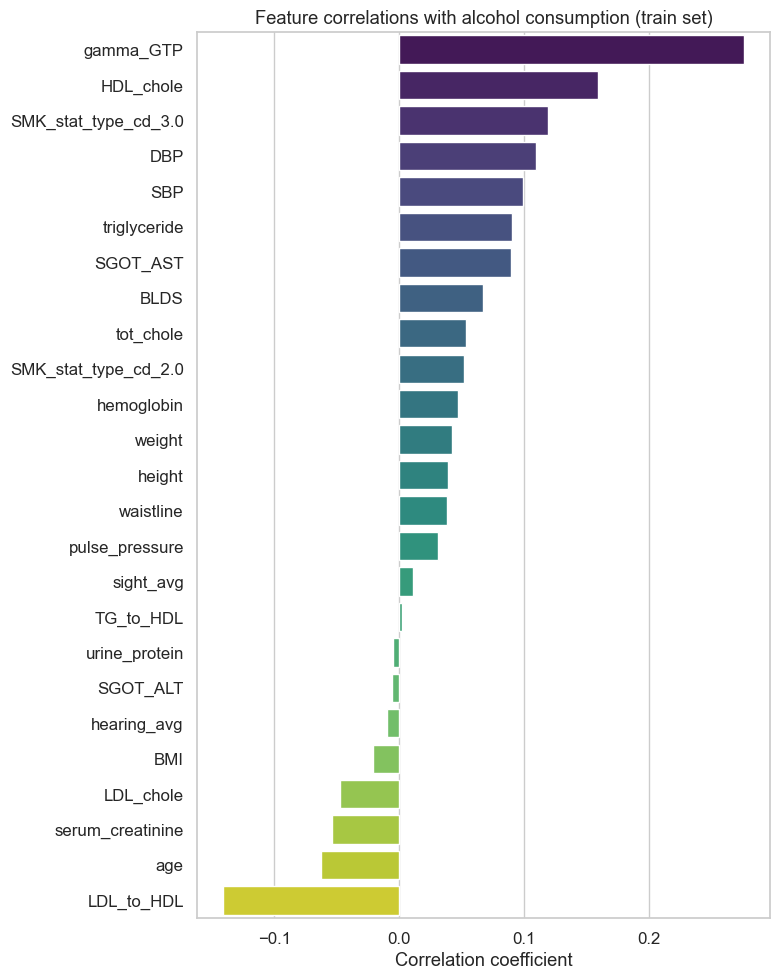

Kept after correlation filter: ['gamma_GTP', 'HDL_chole', 'SMK_stat_type_cd_3.0', 'DBP', 'SBP', 'triglyceride', 'SGOT_AST', 'BLDS', 'tot_chole', 'SMK_stat_type_cd_2.0', 'serum_creatinine', 'age', 'LDL_to_HDL']


In [56]:
# --- Step 1 Correlation-based filtering ---
corr_df = X_train.copy()
corr_df['target'] = y_train

corr_matrix = corr_df.corr(numeric_only=True)
corr_with_target = corr_matrix['target'].drop('target').sort_values(ascending=False)

plt.figure(figsize=(8,10))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette="viridis")
plt.title("Feature correlations with alcohol consumption (train set)")
plt.xlabel("Correlation coefficient")
plt.tight_layout()
plt.show()

selected_corr_features = corr_with_target[abs(corr_with_target) > 0.05].index.tolist()
print("Kept after correlation filter:", selected_corr_features)


Final selected features by RFE:
 ['gamma_GTP', 'HDL_chole', 'DBP', 'SBP', 'triglyceride', 'SGOT_AST', 'BLDS', 'tot_chole', 'serum_creatinine', 'LDL_to_HDL']


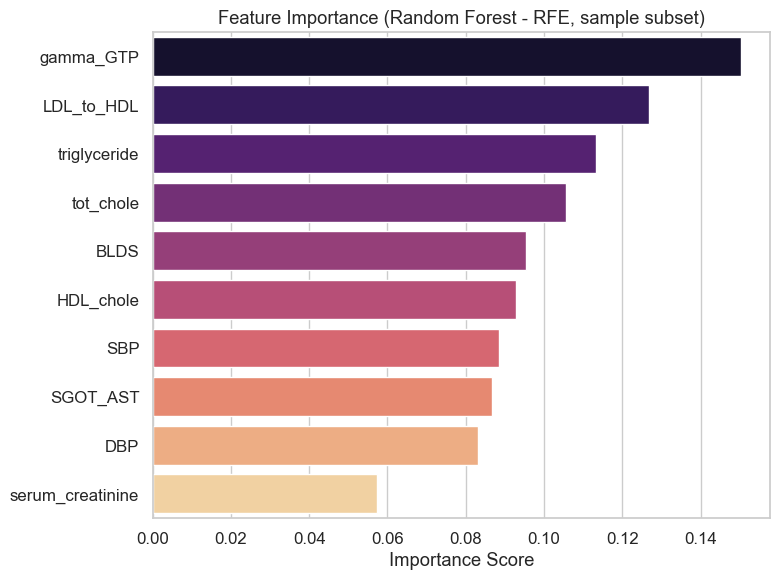

In [57]:
# --- SAMPLE for faster feature selection ---
# Use only 10–15% of data for RFE (same feature relationships, far less compute)
X_sample = X_train.sample(frac=0.15, random_state=42)
y_sample = y_train.loc[X_sample.index]

# --- LIGHTER RandomForest for selection ---
rf_estimator = RandomForestClassifier(
    n_estimators=300,  # fewer trees = faster
    random_state=42,
    n_jobs=-1
)

# --- RFE wrapper ---
rfe = RFE(estimator=rf_estimator, n_features_to_select=10, step=1)
rfe.fit(X_sample[selected_corr_features], y_sample)

selected_features = X_sample[selected_corr_features].columns[rfe.support_].tolist()
print("\nFinal selected features by RFE:\n", selected_features)

# --- Importance scores for selected features ---
importance_scores = pd.Series(
    rfe.estimator_.feature_importances_,
    index=X_sample[selected_corr_features].columns[rfe.support_]
).sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=importance_scores.values, y=importance_scores.index, palette="magma")
plt.title("Feature Importance (Random Forest - RFE, sample subset)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# Save selection for reproducibility
pd.Series(selected_features, name="selected_features").to_csv("selected_features.csv", index=False)

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pandas as pd

# --- Logistic Regression ---
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train[selected_features], y_train)

y_pred = log_reg.predict(X_test[selected_features])
y_prob = log_reg.predict_proba(X_test[selected_features])[:, 1]

log_reg_results = {
    "Model": "Logistic Regression",
    "Accuracy": accuracy_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_prob)
}

print(pd.DataFrame([log_reg_results]))

                 Model  Accuracy        F1   ROC-AUC
0  Logistic Regression  0.715908  0.819963  0.714838


/Users/Hjemmebruker/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [59]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pandas as pd

# --- Decision Tree ---
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train[selected_features], y_train)

y_pred = tree.predict(X_test[selected_features])
y_prob = tree.predict_proba(X_test[selected_features])[:, 1]

tree_results = {
    "Model": "Decision Tree",
    "Accuracy": accuracy_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_prob)
}

print(pd.DataFrame([tree_results]))

           Model  Accuracy       F1   ROC-AUC
0  Decision Tree  0.622473  0.72763  0.557108


In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pandas as pd

# --- Random Forest ---
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train[selected_features], y_train)

y_pred = rf.predict(X_test[selected_features])
y_prob = rf.predict_proba(X_test[selected_features])[:, 1]

rf_results = {
    "Model": "Random Forest",
    "Accuracy": accuracy_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_prob)
}

print(pd.DataFrame([rf_results]))

           Model  Accuracy        F1   ROC-AUC
0  Random Forest  0.708254  0.810911  0.704188


In [61]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Downsample for faster testing
X_small = X_train[selected_features].sample(frac=0.1, random_state=42)
y_small = y_train.loc[X_small.index]

# --- SVM ---
svm_model = SVC(kernel='rbf', probability=True, gamma='scale', random_state=42)

svm_model.fit(X_small, y_small)

y_pred = svm_model.predict(X_test[selected_features])
y_prob = svm_model.predict_proba(X_test[selected_features])[:, 1]

svm_results = {
    "Model": "SVM (RBF Kernel)",
    "Accuracy": accuracy_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_prob)
}
print(svm_results)

{'Model': 'SVM (RBF Kernel)', 'Accuracy': 0.6994007082538818, 'F1': 0.8231145307365553, 'ROC-AUC': 0.5138633638476142}


In [62]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# --- Neural Network ---
nn_model = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=200, early_stopping=True, random_state=42)

nn_model.fit(X_train[selected_features], y_train)

y_pred = nn_model.predict(X_test[selected_features])
y_prob = nn_model.predict_proba(X_test[selected_features])[:, 1]

nn_results = {
    "Model": "Neural Network",
    "Accuracy": accuracy_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_prob)
}
print(nn_results)

{'Model': 'Neural Network', 'Accuracy': 0.7125034050667393, 'F1': 0.8143012985184924, 'ROC-AUC': 0.7093941142395026}


## TASK 7 - BAGGING N BOOSTING

### Imports

In [63]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

### Split and fix

In [64]:
X = df_encoded.drop(columns=['DRK_YN_Y'])
y = df_encoded['DRK_YN_Y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Bagging

In [86]:
bag_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=5, random_state=42),
    n_estimators=50,
    random_state=42,
    n_jobs=-1
)
bag_model.fit(X_train, y_train)
y_pred_bag = bag_model.predict(X_test)
acc_bag = accuracy_score(y_test, y_pred_bag)
f1_bag = f1_score(y_test, y_pred_bag)
roc_bag = roc_auc_score(y_test, bag_model.predict_proba(X_test)[:, 1])

### Boosting

In [87]:
# adaboost boosting
ada_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
    n_estimators=100,
    learning_rate=0.5,
    random_state=42
)

ada_model.fit(X_train, y_train)
y_pred_ada = ada_model.predict(X_test)
acc_ada = accuracy_score(y_test, y_pred_ada)
f1_ada = f1_score(y_test, y_pred_ada)
roc_ada = roc_auc_score(y_test, ada_model.predict_proba(X_test)[:, 1])

# gradient boosting
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
acc_gb = accuracy_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)
roc_gb = roc_auc_score(y_test, gb_model.predict_proba(X_test)[:, 1])

### Results

In [88]:
print(f"Bagging:  acc={acc_bag:.4f}, f1={f1_bag:.4f}, roc_auc={roc_bag:.4f}")
print(f"AdaBoost: acc={acc_ada:.4f}, f1={f1_ada:.4f}, roc_auc={roc_ada:.4f}")
print(f"Gradient Boosting: acc={acc_gb:.4f}, f1={f1_gb:.4f}, roc_auc={roc_gb:.4f}")

Bagging:  acc=0.7199, f1=0.8227, roc_auc=0.7295
AdaBoost: acc=0.7271, f1=0.8267, roc_auc=0.7515
Gradient Boosting: acc=0.7332, f1=0.8275, roc_auc=0.7621


## TRANSFER LEARNING Task 8

In [68]:
df_encoded

,age,height,weight,waistline,SBP,DBP,BLDS,tot_chole,HDL_chole,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,BMI,pulse_pressure,LDL_to_HDL,TG_to_HDL,sight_avg,hearing_avg,SMK_stat_type_cd_2.0,SMK_stat_type_cd_3.0,DRK_YN_Y
0,50,175.0,4.394449,91.0,145.0,87.0,4.564348,5.308268,4.343805,4.653960,4.672829,17.6,1,1.1,3.401197,3.555348,2.944439,1.434922,58.0,1.071402,1.075745,1.35,1.0,0,0,0
1,50,165.0,4.110874,80.0,138.0,82.0,4.624973,5.298317,4.127134,4.770685,4.653960,13.8,1,0.8,2.995732,2.564949,3.258097,1.509963,56.0,1.155931,1.127649,1.10,1.0,0,0,0
2,50,165.0,4.025352,75.0,142.0,92.0,4.605170,5.389072,4.356709,4.564348,5.451038,13.8,3,0.8,3.401197,3.713572,3.637586,1.478550,50.0,1.047660,1.251183,1.35,1.0,0,1,1
3,55,170.0,4.330733,84.0,145.0,85.0,4.653960,5.384495,4.043051,4.955827,4.615121,15.1,1,0.8,3.496508,3.178054,3.295837,1.498524,60.0,1.225764,1.141494,1.05,1.0,0,0,1
4,45,157.5,4.025352,79.2,118.0,70.0,4.510860,5.214936,3.761200,4.875197,4.025352,12.9,1,0.8,2.995732,2.708050,2.995732,1.622717,48.0,1.296181,1.070231,1.00,1.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184456,45,177.5,4.394449,87.0,151.0,97.0,4.682131,5.209486,3.828641,4.762174,4.653960,17.0,1,0.9,3.218876,3.178054,3.258097,1.394786,54.0,1.243829,1.215564,1.20,1.0,1,0,1
184457,50,175.0,4.330733,81.0,140.0,80.0,4.584967,5.356586,4.043051,4.867534,4.867534,14.8,1,0.8,3.295837,2.995732,3.871201,1.414117,60.0,1.203926,1.203926,0.75,1.0,0,1,1
184458,55,170.0,4.330733,84.0,139.0,89.0,4.574711,5.451038,3.970292,4.948760,5.293305,17.3,1,0.9,3.218876,3.496508,3.688879,1.498524,50.0,1.246447,1.333228,1.65,1.5,1,0,0
184459,45,175.0,4.394449,92.1,114.0,80.0,4.488636,5.293305,3.850148,4.836282,4.890349,15.0,1,1.0,3.295837,3.610918,3.332205,1.434922,34.0,1.256129,1.270172,1.50,1.0,0,0,0


In [69]:
largeset_encoded

,age,height,weight,waistline,SBP,DBP,BLDS,tot_chole,HDL_chole,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,BMI,pulse_pressure,LDL_to_HDL,TG_to_HDL,sight_avg,hearing_avg,sex_Male,SMK_stat_type_cd_2.0,SMK_stat_type_cd_3.0,DRK_YN_Y
0,35,170.0,4.330733,90.0,120.0,80.0,4.605170,5.267858,3.891820,4.844187,4.532599,17.1,1,1.0,3.091042,3.583519,3.713572,1.498524,40.0,1.244710,1.164648,1.00,1.0,1,0,0,1
1,30,180.0,4.394449,89.0,130.0,82.0,4.672829,5.433722,4.025352,5.003946,4.804021,15.8,1,0.9,3.044522,3.610918,3.332205,1.356311,48.0,1.243108,1.193441,1.05,1.0,1,0,1,0
2,40,165.0,4.330733,91.0,120.0,70.0,4.595120,4.919981,3.737670,4.317488,4.653960,15.8,1,0.9,3.749504,3.496508,4.189655,1.590719,50.0,1.155128,1.245150,1.35,1.0,1,0,0,0
3,45,150.0,4.025352,69.0,101.0,58.0,4.499810,5.283204,4.204693,4.753590,4.330733,12.3,1,0.8,2.995732,2.564949,2.564949,1.789045,43.0,1.130544,1.029976,0.45,1.0,0,0,0,0
4,35,175.0,4.189655,84.2,132.0,80.0,4.553877,5.225747,4.077537,4.682131,4.624973,14.4,1,0.8,2.944439,2.944439,3.583519,1.368051,52.0,1.148274,1.134256,1.10,1.0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806880,70,165.0,4.110874,78.0,137.0,78.0,4.543295,5.123964,4.060443,4.499810,4.663439,16.1,1,1.0,3.178054,2.639057,3.496508,1.509963,59.0,1.108207,1.148505,0.85,1.0,1,0,0,1
806881,50,150.0,3.931826,72.6,116.0,74.0,4.691348,5.187386,3.891820,4.663439,4.836282,15.2,1,0.8,3.367296,3.295837,3.401197,1.747478,42.0,1.198267,1.242679,1.00,1.0,0,0,0,0
806882,35,170.0,4.330733,86.0,119.0,83.0,4.430817,4.897840,3.713572,4.442651,3.828641,15.8,1,1.1,2.708050,2.890372,2.772589,1.498524,36.0,1.196328,1.030986,1.25,1.0,1,0,0,0
806883,40,155.0,3.931826,68.0,110.0,70.0,4.510860,5.327876,4.574711,4.356709,5.062595,14.3,1,0.8,3.433987,3.332205,2.890372,1.636556,40.0,0.952346,1.106648,0.85,1.0,0,0,1,1


### IMPORTS

In [70]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier

In [71]:
TARGET = "DRK_YN_Y"

X_src = largeset_encoded.drop(columns=[TARGET])
y_src = largeset_encoded[TARGET]

# Target (small)
X_tgt = df_encoded.drop(columns=[TARGET])
y_tgt = df_encoded[TARGET]

### Separate split and scaling 

In [72]:
X_src_train, X_src_test, y_src_train, y_src_test = train_test_split(
    X_src, y_src, test_size=0.2, random_state=42, stratify=y_src
)
X_tgt_train, X_tgt_test, y_tgt_train, y_tgt_test = train_test_split(
    X_tgt, y_tgt, test_size=0.2, random_state=42, stratify=y_tgt
)

sc_src = StandardScaler().fit(X_src_train)
X_src_train_s = sc_src.transform(X_src_train)
X_src_test_s  = sc_src.transform(X_src_test)

sc_tgt = StandardScaler().fit(X_tgt_train)
X_tgt_train_s = sc_tgt.transform(X_tgt_train)
X_tgt_test_s  = sc_tgt.transform(X_tgt_test)

### Pretraining source dataset

In [73]:
xgb_source = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method="hist",
    n_jobs=-1,
    eval_metric="logloss",
    warm_start=True
)

In [74]:
xgb_source.fit(X_src_train_s, y_src_train)

y_pred_src = xgb_source.predict(X_src_test_s)
acc_src = accuracy_score(y_src_test, y_pred_src)
f1_src = f1_score(y_src_test, y_pred_src)
roc_src = roc_auc_score(y_src_test, xgb_source.predict_proba(X_src_test_s)[:, 1])
print("Pretrained (source) accuracy:", round(acc_src, 4))

/Users/Hjemmebruker/anaconda3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [14:53:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "warm_start" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pretrained (source) accuracy: 0.7411


### Finetuning on target dataset

In [75]:
xgb_source.set_params(n_estimators=300, learning_rate=0.05)
xgb_source.fit(X_tgt_train_s, y_tgt_train)

/Users/Hjemmebruker/anaconda3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [14:53:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "warm_start" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [76]:
y_pred_transfer = xgb_source.predict(X_tgt_test_s)
acc_transfer = accuracy_score(y_tgt_test, y_pred_transfer)
f1_transfer = f1_score(y_tgt_test, y_pred_transfer)
roc_transfer = roc_auc_score(y_tgt_test, xgb_source.predict_proba(X_tgt_test_s)[:, 1])
print("Transfer learning (fine-tuned) accuracy:", round(acc_transfer, 4))

Transfer learning (fine-tuned) accuracy: 0.735


### Baselinemodel without transferlearning

In [77]:
xgb_base = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method="hist",
    n_jobs=-1,
    eval_metric="logloss"
)

In [78]:
xgb_base.fit(X_tgt_train_s, y_tgt_train)

y_pred_base = xgb_base.predict(X_tgt_test_s)
acc_base = accuracy_score(y_tgt_test, y_pred_base)
f1_base = f1_score(y_tgt_test, y_pred_base)
roc_base = roc_auc_score(y_tgt_test, xgb_base.predict_proba(X_tgt_test_s)[:, 1])
print("Baseline (no transfer) accuracy:", round(acc_base, 4))

Baseline (no transfer) accuracy: 0.7327


### Performance comparison

In [79]:
print("\n=== Model Comparison ===")
print(f"Pretrained (source):  acc={acc_src:.4f}, f1={f1_src:.4f}, roc_auc={roc_src:.4f}")
print(f"Transfer (fine-tuned): acc={acc_transfer:.4f}, f1={f1_transfer:.4f}, roc_auc={roc_transfer:.4f}")
print(f"Baseline (no transfer): acc={acc_base:.4f}, f1={f1_base:.4f}, roc_auc={roc_base:.4f}")


=== Model Comparison ===
Pretrained (source):  acc=0.7411, f1=0.7083, roc_auc=0.8195
Transfer (fine-tuned): acc=0.7350, f1=0.8247, roc_auc=0.7671
Baseline (no transfer): acc=0.7327, f1=0.8225, roc_auc=0.7646


## Visualization 8A

In [80]:
largeset_encoded.shape

(801962, 27)

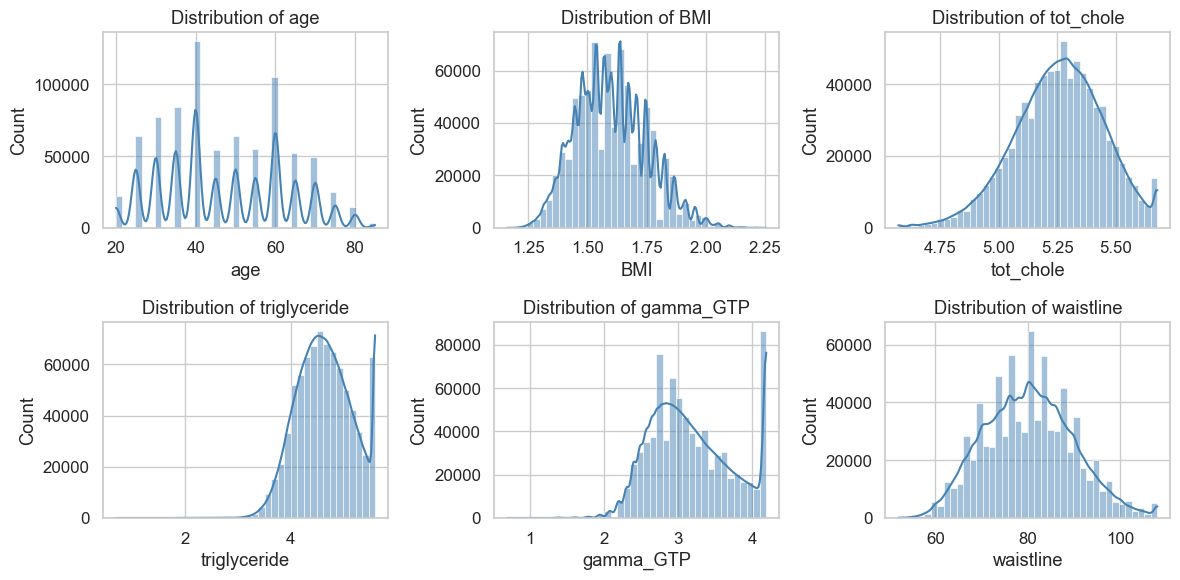

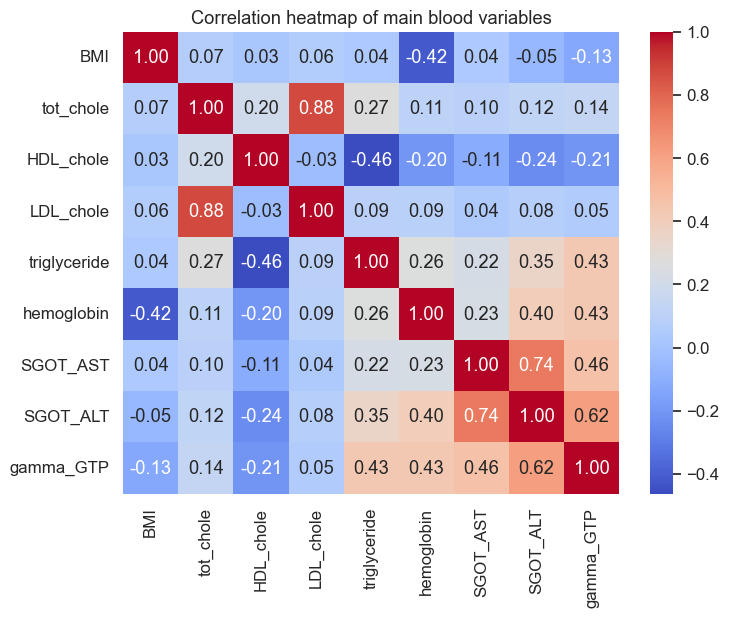

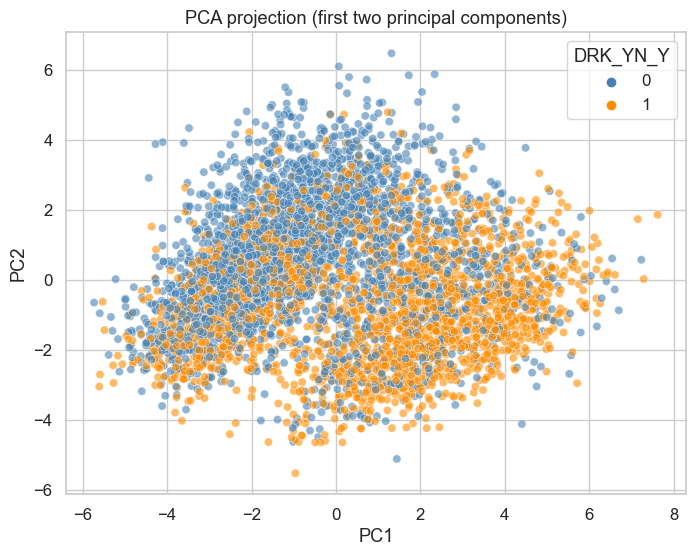

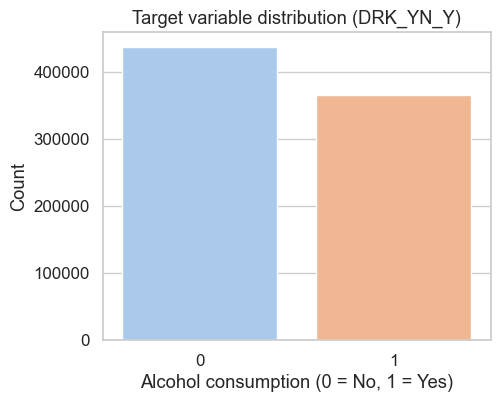

In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Sett stiler
sns.set(style="whitegrid", font_scale=1.1)

# ====== 1. Feature distributions ======
features = ['age', 'BMI', 'tot_chole', 'triglyceride', 'gamma_GTP', 'waistline']
plt.figure(figsize=(12, 6))
for i, col in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(largeset_encoded[col], bins=40, kde=True, color="steelblue")
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()


# ====== 2. Correlation heatmap ======
corr_cols = ['BMI', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 
              'hemoglobin', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP']
corr = largeset_encoded[corr_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Correlation heatmap of main blood variables")
plt.show()


# ====== 3. PCA visualization ======
X = largeset_encoded.drop(columns=['DRK_YN_Y'])
y = largeset_encoded['DRK_YN_Y']

X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['DRK_YN_Y'] = y.values

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pca_df.sample(5000, random_state=42),  # tar et utvalg for tydelig plot
    x="PC1", y="PC2", hue="DRK_YN_Y",
    palette={0: "steelblue", 1: "darkorange"}, alpha=0.6
)
plt.title("PCA projection (first two principal components)")
plt.show()


# ====== 4. Target distribution ======
plt.figure(figsize=(5, 4))
sns.countplot(x='DRK_YN_Y', data=largeset_encoded, palette="pastel")
plt.title("Target variable distribution (DRK_YN_Y)")
plt.xlabel("Alcohol consumption (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


In [82]:
summary = largeset_encoded.describe().T
summary[['mean', 'std', 'min', '25%', '50%', '75%', 'max']].head(100)


,mean,std,min,25%,50%,75%,max
age,47.021704,15.516958,20.000000,35.000000,45.000000,60.000000,85.000000
height,160.955818,9.430305,132.500000,155.000000,160.000000,170.000000,190.000000
weight,4.120033,0.191079,3.511545,4.025352,4.110874,4.262680,4.537961
waistline,80.238834,9.688498,52.000000,73.000000,80.000000,87.000000,108.000000
SBP,121.703709,14.284751,80.000000,110.000000,120.000000,130.000000,160.000000
DBP,75.184722,9.224480,55.000000,70.000000,75.000000,80.000000,95.000000
BLDS,4.573311,0.131042,4.197202,4.488636,4.564348,4.644391,4.840242
tot_chole,5.257687,0.192401,4.569543,5.135798,5.262690,5.389072,5.678465
HDL_chole,4.043747,0.249225,2.890372,3.871201,4.043051,4.219508,4.584967
LDL_chole,4.681946,0.319779,3.113515,4.499810,4.709530,4.905275,5.310740


In [83]:
largeset_encoded['DRK_YN_Y'].value_counts(normalize=True)

0    0.544759
1    0.455241
Name: DRK_YN_Y, dtype: float64

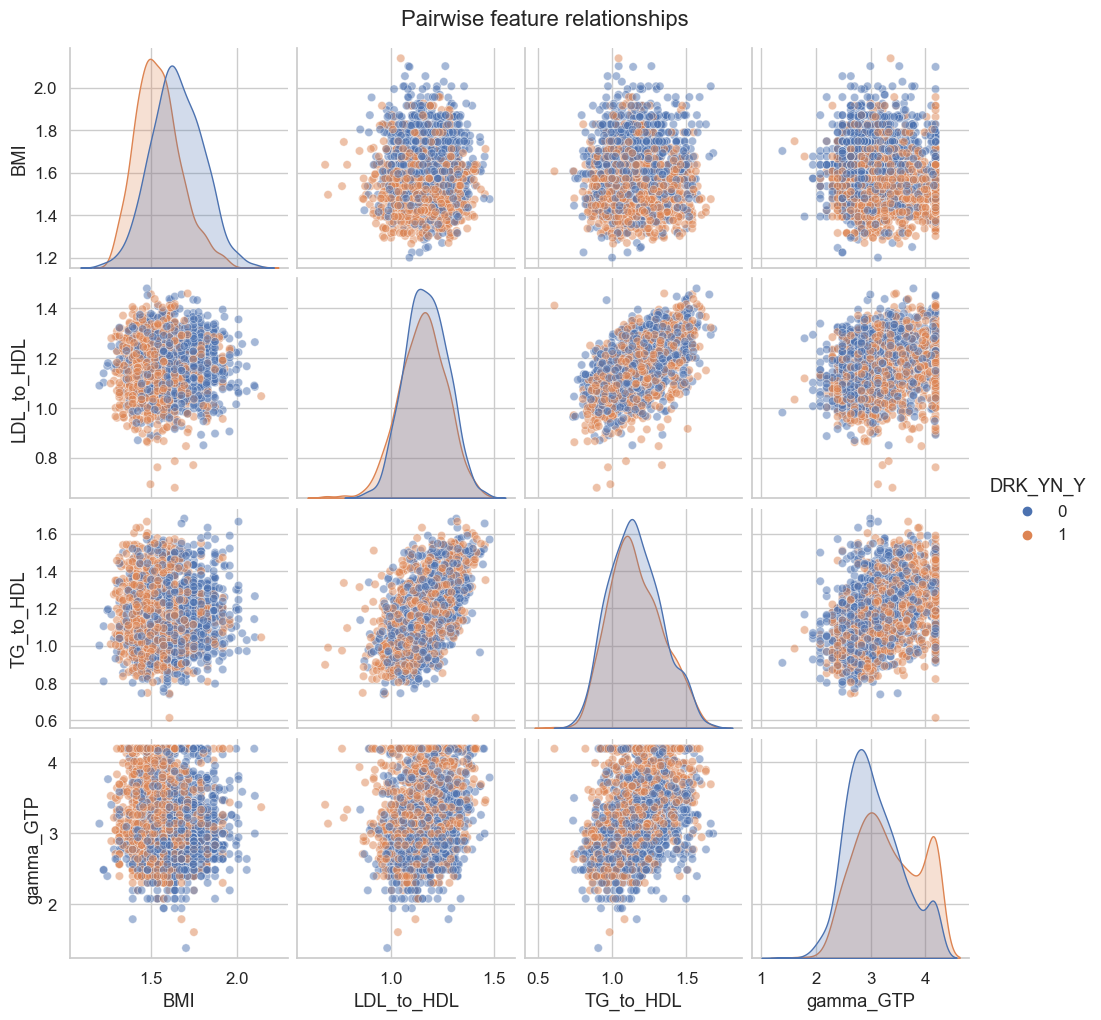

In [84]:
sns.pairplot(
    largeset_encoded.sample(2000, random_state=42),
    vars=['BMI', 'LDL_to_HDL', 'TG_to_HDL', 'gamma_GTP'],
    hue='DRK_YN_Y', diag_kind='kde', plot_kws={'alpha':0.5}
)
plt.suptitle("Pairwise feature relationships", y=1.02)
plt.show()


## PERFORMANCE COMPARISON Task 9